# Parametres du probleme + maillage

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm


# Paramètres de la simulation
#
# Physiques
#
#  a,b = vitesses d'onde
#  xmin,ymin, lx_dom, ly_dom : définissent le domaine de calcul
#
# Numériques
#
# imax, jmax : Nombre de cellules de calcul
# cfl : nombre CFL
# itermax : Nombre d'itérations a effectuer
# freq_ech : Fréquence des sorties graphiques

# Abscisse minimale
xmin=0
# Ordonnée minimale
ymin=0

# Longueur du domaine suivant x
l_dom_x=0.99
# Longueur du domaine suivant y
l_dom_y=1.0

# Nombre de cellules
imax=41
jmax=21

# Nombre CFL
cfl=0.5

# Choix de l'initialisation
# iinlet=0 (créneau)
iinlet=0
# Choix du schéma
# 1 (schéma CIR ou de Roe)  2 (LW)
ischema=2

# Fréquence des sorties
freq_ech=1


dx = l_dom_x / (imax-1)
dy = l_dom_y / (jmax-1)

#Affichage
print('Nb cellules suivant x : ' +str(imax))
print('Nb cellules suivant y : ' + str(jmax))
print('Abscisse minimale : ' + str(xmin))
print('Ordonnée minimale : ' +str(ymin))
print('Abscisse maximale : ' + str(xmin+l_dom_x,))
print('Ordonnée maximale : ' +str(ymin+l_dom_y))
print("Pas d'espace suivant x : "+str(dx))
print("Pas d'espace suivant y : "+str(dy))
print('Nombre CFL : '+str(cfl))
print('Fréquence des sorties : '+str(freq_ech))

#Création de x et y et de rho et rhoex

x = [xmin + (i-1-1)*dx for i in range(1,imax+1)]
y = [ymin + (j-1-1)*dy for j in range(1,jmax+1)]

Nb cellules suivant x : 41
Nb cellules suivant y : 21
Abscisse minimale : 0
Ordonnée minimale : 0
Abscisse maximale : 0.99
Ordonnée maximale : 1.0
Pas d'espace suivant x : 0.02475
Pas d'espace suivant y : 0.05
Nombre CFL : 0.5
Fréquence des sorties : 1


# Vitesse d'onde (cas a et b constants)

In [2]:
# Vitesse d'onde
a = [0 for x in y]
b = [1 for z in x] 


# Vitesse d'onde (cas a et b variables)

In [3]:
# Vitesse d'onde
a = [x for x in y]
b = [(1-q) for q in x]

# Fonctions (cas a et b constants)

In [4]:
def c1(xi):
    return xi

def c2(xi):
    return 1-xi



def f1_phys(rho,i,j):
	return a[j]*rho

def f2_phys(rho,i,j):
	return b[i]*rho

def a1_phys(rho,i,j):
	return a[j]

def a2_phys(rho,i,j):
	return b[i]

def q1_num(rhol,rhor,i,j):
	if ischema == 1:
		return abs(a)
	elif ischema ==2:
		return a[j]*dt

def q2_num(rhol,rhor,i,j):
	if ischema == 1:
		return abs(b[i])
	elif ischema == 2:
		return b[i]*dt

def rho_inlet(xi):
    if iinlet == 0:
        if xi > 0.2 and xi < 0.5:
            return 1
        else:
            return 0


def rho_ex(x,y):
	return rho_inlet(x-(a[0]/b[0])*y)


# Fonctions cas a et b variables 

In [5]:
def c1(xi):
    return xi

def c2(xi):
    return 1-xi


def f1_phys(rho,i,j):
	return a[j]*rho

def f2_phys(rho,i,j):
	return b[i]*rho

def a1_phys(rho,i,j):
	return a[j]

def a2_phys(rho,i,j):
	return b[i]

def q1_num(rhol,rhor,i,j):
	if ischema == 1:
		return abs(a[j])
	elif ischema ==2:
		return a[j]*dt

def q2_num(rhol,rhor,i,j):
	if ischema == 1:
		return abs(b[i])
	elif ischema == 2:
		return b[i]*dt

def rho_inlet(xi):
    if iinlet == 0:
        if xi > 0.2 and xi < 0.5:
            return 1
        else:
            return 0

def rho_ex(x,y):
    R=np.sqrt((x-1)**2+y**2)   #ATTENTION (x-1) car on sait que l'origine du cercle est décalée à gauche
    return rho_inlet(l_dom_x-R)


# Creation de rho et de rhoex et conditions au limites

In [6]:
rho = [[0 for j in range(1,jmax+1)] for i in range(1,imax+1)]
for i in range(1,imax+1):
	for j in range(1,jmax+1):
		rho[i-1][j-1]=0
rhoex = [[0 for j in range(1,jmax+1)] for i in range(1,imax+1)]
for i in range(1,imax):
	for j in range(1,jmax):
		rhoex[i-1][j-1]=rho_ex(x[i-1],y[j-1])

rhoold = [[0 for j in range(jmax)] for i in range(imax)]

print('La simulation démarre...')


#Conditions aux limites

#	Conditions d'entrée

for i in range(1,imax+1):
	rho[i-1][0]=rho_inlet(x[i-1])
for j in range(1,jmax+1):
	rho[0][j-1]=rho_inlet(x[0])

#	Conditions de sortie

for i in range(1,imax+1):
	rho[i-1][jmax-1]=rho[i-1][jmax-1-1]
for j in range(1,jmax+1):
	rho[imax-1][j-1]=rho[imax-1-1][j-1]

La simulation démarre...


# Boucle principale 

In [7]:
#init

norm_res = 1
iteration = 0

#Fonctions de calcul de a1max et a2max

def c_a1max(crho):
	eps = 1E-6
	L = [[abs(a1_phys(k,1,j)) for k in crho] for j in range(len(y))]
	return max(max(max(L)), eps)

def c_a2max(crho):
	eps = 1E-6
	L = [[abs(a2_phys(k,i,1)) for k in crho] for i in range(len(x))]
	return max(max(max(L)), eps)

#On décremente i et j de 1
#Fonction calcul flux num

def c_flux_num(crho):
	if ischema == 1:
		q1 = [[0 for j in range(1,jmax-1+1)] for i in range(1,imax-1+1)]
		cf1num = [[0 for j in range(1,jmax-1+1)] for i in range(1,imax-1+1)]
		for i in range(1,imax-1+1):
			i = i-1
			for j in range(2,jmax-1+1):
				j = j-1
				q1[i][j] = q1_num(crho[i][j], crho[i+1][j],i,j)
				cf1num[i][j] = 0.5*(f1_phys(crho[i][j],i,j)+f1_phys(crho[i+1][j],i,j))-0.5*q1[i][j]*(crho[i+1][j]-crho[i][j])

		q2 = [[0 for j in range(1,jmax-1+1)] for i in range(1,imax-1+1)]
		cf2num = [[0 for j in range(1,jmax-1+1)] for i in range(1,imax-1+1)]
		for i in range(2,imax-1+1):
			i = i-1
			for j in range(1,jmax-1+1):
				j = j-1
				q2[i][j] = q2_num(crho[i][j],crho[i][j+1],i,j)
				cf2num[i][j] = 0.5*(f2_phys(crho[i][j],i,j)+f2_phys(crho[i][j+1],i,j))-0.5*q2[i][j]*(crho[i][j+1]-crho[i][j])

		return cf1num,cf2num

	elif ischema == 2:
		q1 = [[0 for j in range(1,jmax-1+1)] for i in range(1,imax-1+1)]
		cf1num = [[0 for j in range(1,jmax-1+1)] for i in range(1,imax-1+1)]
		for i in range(1,imax-1+1):
			i = i-1
			for j in range(2,jmax-1+1):
				j = j-1
				q1[i][j] = q1_num(crho[i][j], crho[i+1][j],i,j)
				res1 = (f1_phys(crho[i+1][j],i,j)-f1_phys(crho[i][j],i,j))/dx + 0.25*(f2_phys(crho[i][j+1],i,j)+f2_phys(crho[i+1][j+1],i,j)-f2_phys(crho[i][j-1],i,j)-f2_phys(crho[i+1][j-1],i,j))/dy
				cf1num[i][j] = 0.5*(f1_phys(crho[i][j],i,j)+f1_phys(crho[i+1][j],i,j))-0.5*q1[i][j]*res1
		q2 = [[0 for j in range(1,jmax-1+1)] for i in range(1,imax-1+1)]
		cf2num = [[0 for j in range(1,jmax-1+1)] for i in range(1,imax-1+1)]
		for i in range(2,imax-1+1):
			i = i-1
			for j in range(1,jmax-1+1):
				j = j-1
				q2[i][j] = q2_num(crho[i][j],crho[i][j+1],i,j)
				res2 = (f2_phys(crho[i][j+1],i,j)-f2_phys(crho[i][j],i,j))/dy + 0.25*(f1_phys(crho[i+1][j],i,j)+f1_phys(crho[i+1][j+1],i,j)-f1_phys(crho[i-1][j],i,j)-f1_phys(crho[i-1][j+1],i,j))/dx
				cf2num[i][j] = 0.5*(f2_phys(crho[i][j],i,j)+f2_phys(crho[i][j+1],i,j))-0.5*q2[i][j]*res2

		return cf1num,cf2num
    
#boucle

while norm_res > 1E-5:

	#pas de temps
	a1max = c_a1max(rho)
	a2max = c_a2max(rho)

	dt = cfl*min(dx/a1max,dy/a2max)

	#flux num

	f1num,f2num = c_flux_num(rho)

	

	for i in range(imax):
		for j in range(jmax):
			rhoold[i][j] = rho[i][j]

	for i in range(2,imax-1+1):
		i = i-1
		for j in range(2,jmax-1+1):
			j = j-1
			rho[i][j] = rho[i][j] - (dt/dx)*(f1num[i][j]-f1num[i-1][j])-(dt/dy)*(f2num[i][j]-f2num[i][j-1])

	#Conditions aux limites

	#	conditions d'entrée

	for i in range(1,imax+1):
		rho[i-1][0]=rho_inlet(x[i-1])
	for j in range(1,jmax+1):
		rho[0][j-1]=rho_inlet(x[0])

	#	conditions de sortie

	for i in range(1,imax+1):
		rho[i-1][jmax-1]=rho[i-1][jmax-1-1]
	for j in range(1,jmax+1):
		rho[imax-1][j-1]=rho[imax-1-1][j-1]

	iteration += 1

	#calcul norm

	norm_res = 0
	for i in range(1,imax+1):
		i = i-1
		for j in range(1,jmax+1):
			j = j-1
			norm_res += (rho[i][j]-rhoold[i][j])**2
	norm_res = np.sqrt(norm_res/(imax*jmax))

	norm_err = 0
	for i in range(1,imax+1):
		i = i-1
		for j in range(1,jmax+1):
			j = j-1
			norm_err += (rho[i][j]-rhoex[i][j])**2
	norm_err = np.sqrt(norm_err/(imax*jmax))

# Traçage

<IPython.core.display.Javascript object>


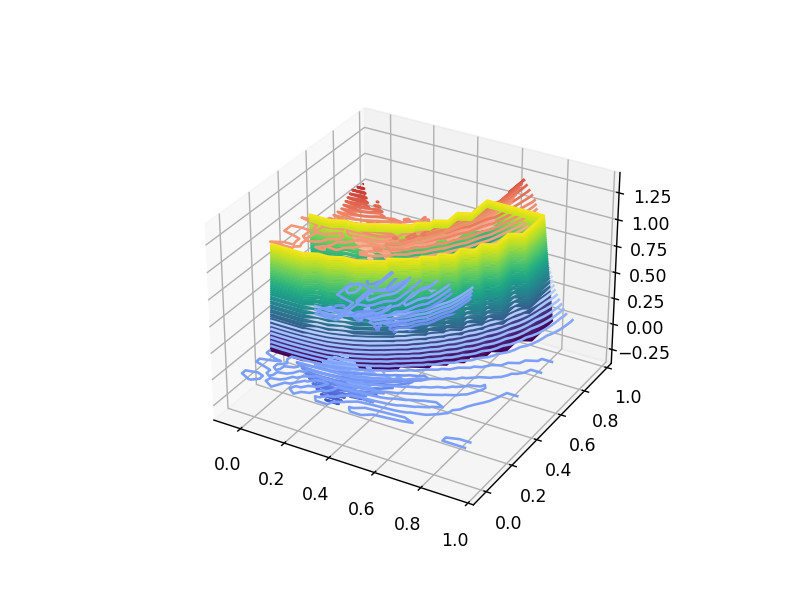

In [8]:
X , Y = np.meshgrid(y,x)

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.contour3D(X,Y,rho, 50, cmap=cm.coolwarm)
ax.contour3D(X,Y,rhoex, 50)
plt.show()
fig.savefig('demo.png', bbox_inches='tight')